#### <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea">Twitter US Airline Sentiment 
##### <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea">Project 9

### by Anthony Amabile
Twitter has been called the "global town square" recently by billionarie Elon Musk as he tries to purchase the company for $43B. Musk is eluding to the vast amount of users the platform has, 330 million and growing, which all have a voice. 

Businesses can tap into this vast user base to discover new trends, imtimately understand customers' perceptions of thiers and their competitors products and services, as well as be able to have a good understanding of who their customers are. 

The challenge, however, is that there's so much information being shared on the platform it's difficult to synthesize it all as well as for brands to quickly detect negative social mentions that could harm their business.

This project undertakes the opportunity to analyze sentiment of each major U.S. airline using data from Twitter scrapped from 2015. A multi category classification analysis follows using NLP to categorize sentiment from tweets into positive, negative and neutral. 


In [180]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:

# install and import necessary libraries.

!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.
from datetime import date

# Download Stopwords.
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF



import matplotlib.pyplot as plt                         
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18


from wordcloud import WordCloud,STOPWORDS

from sklearn.ensemble import RandomForestClassifier       # Import Random forest Classifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report         # Import Classification report
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [182]:
data = pd.read_csv('/content/drive/MyDrive/Texas AI ML/Tweets.csv')

In [183]:
df = data.copy()

In [184]:
df.sample(5, random_state=1)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
8515,568198336651649027,positive,100%,NaN,NaN,Delta,NaN,GenuineJack,NaN,0,@JetBlue I'll pass along the advice. You guys ...,NaN,2015-02-18 16:00:14 -0800,Massachusetts,Central Time (US & Canada)
3439,568438094652956673,negative,70%,Lost Luggage,70%,United,NaN,vina_love,NaN,0,@united I sent you a dm with my file reference...,NaN,2015-02-19 07:52:57 -0800,ny,Quito
6439,567858373527470080,positive,100%,NaN,NaN,Southwest,NaN,Capt_Smirk,NaN,0,@SouthwestAir Black History Commercial is real...,NaN,2015-02-17 17:29:21 -0800,La Florida,Eastern Time (US & Canada)
5112,569336871853170688,negative,100%,Late Flight,100%,Southwest,NaN,scoobydoo9749,NaN,0,@SouthwestAir why am I still in Baltimore?! @d...,"[39.1848041, -76.6787131]",2015-02-21 19:24:22 -0800,"Tallahassee, FL",America/Chicago
5645,568839199773732864,positive,68%,NaN,NaN,Southwest,NaN,laurafall,NaN,0,@SouthwestAir SEA to DEN. South Sound Volleyba...,NaN,2015-02-20 10:26:48 -0800,NaN,Pacific Time (US & Canada)


In [185]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the original dataset.')

There are 14640 rows and 15 columns in the original dataset.


In [186]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [187]:
df.isnull().sum(axis=0)          

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [188]:
min_dt = min(data['tweet_created']).format('YYYY-MM-DD') 
max_dt =max(data['tweet_created']).format('YYYY-MM-DD') 


In [189]:
print(f'The tweets in this data are from {min_dt} to {max_dt}.')

The tweets in this data are from 2015-02-16 23:36:05 -0800 to 2015-02-24 11:53:37 -0800.


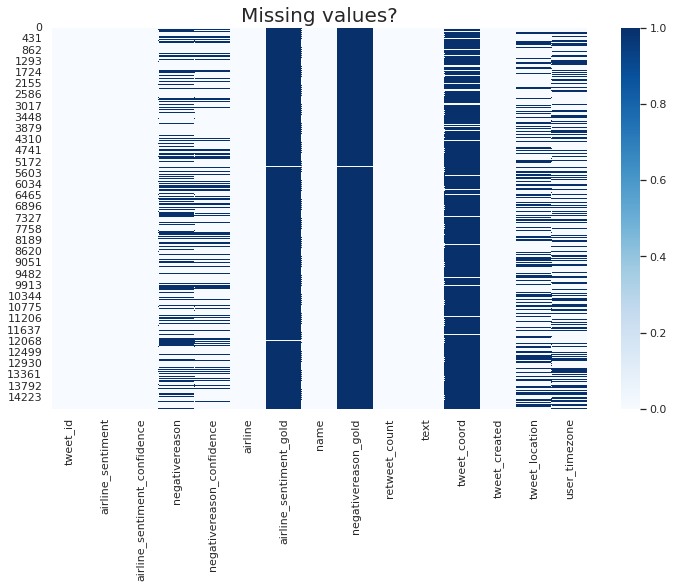

In [190]:
plt.figure(figsize=(12,7))
sns.heatmap(data.isnull(), cmap = "Blues")                       #Visualization of missing value using heatmap
plt.title("Missing values?", fontsize = 20)
plt.show()

* The lines in the above heatmap will visualize the location of missing values (i.e. the missing value indexes in the dataframe). 
* You can see airline_sentiment_gold and negativereason_gold have a lot of missing values.

In [191]:
# check the missing values for all the columns
def return_missing_values(data_frame):
    missing_values = data_frame.isnull().sum()
    missing_values = missing_values[missing_values>0]
    missing_values.sort_values(inplace=True)
    return missing_values

#plot the count of missing values in every column 
def plot_missing_values(data_frame):
    missing_values = return_missing_values(data_frame)
    missing_values = missing_values.to_frame()
    missing_values.columns = ['count']
    missing_values.index.names = ['Name']
    missing_values['Name'] = missing_values.index
    sns.set(style='darkgrid')
    sns.barplot(x='Name', y='count', data=missing_values)
    plt.title('Bar plot for Null Values in each column',)
    plt.xticks(rotation=90)
    plt.show()

In [192]:
# get the count of missing values in every column of the dataframe
return_missing_values(df)

negativereason_confidence     4118
tweet_location                4733
user_timezone                 4820
negativereason                5462
tweet_coord                  13621
airline_sentiment_gold       14600
negativereason_gold          14608
dtype: int64

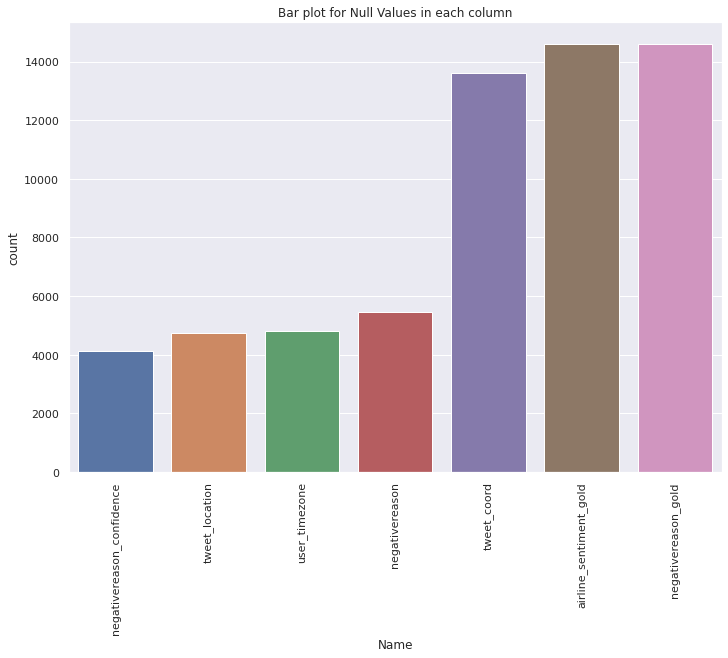

In [193]:
#plotting the count of missing values 
plot_missing_values(df)

* We can see again that more data is missing from the **airline_sentiment_gold** and **neagivereason_gold** columns.

In [194]:
# checking for duplicate values
dup_data = df.duplicated().sum()

print(f'There are {dup_data} duplicates.')

There are 36 duplicates.


In [195]:
df.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
airline_sentiment_gold              3
name                             7701
negativereason_gold                13
retweet_count                      18
text                            14427
tweet_coord                       832
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

In [196]:
#get the unique values of every column
def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

    
unidf = return_unique_values(data)
print(unidf)



                        Features  Uniques
0                       tweet_id    14485
1              airline_sentiment        3
2   airline_sentiment_confidence     1023
3                 negativereason       10
4      negativereason_confidence     1410
5                        airline        6
6         airline_sentiment_gold        3
7                           name     7701
8            negativereason_gold       13
9                  retweet_count       18
10                          text    14427
11                   tweet_coord      832
12                 tweet_created    14247
13                tweet_location     3081
14                 user_timezone       85


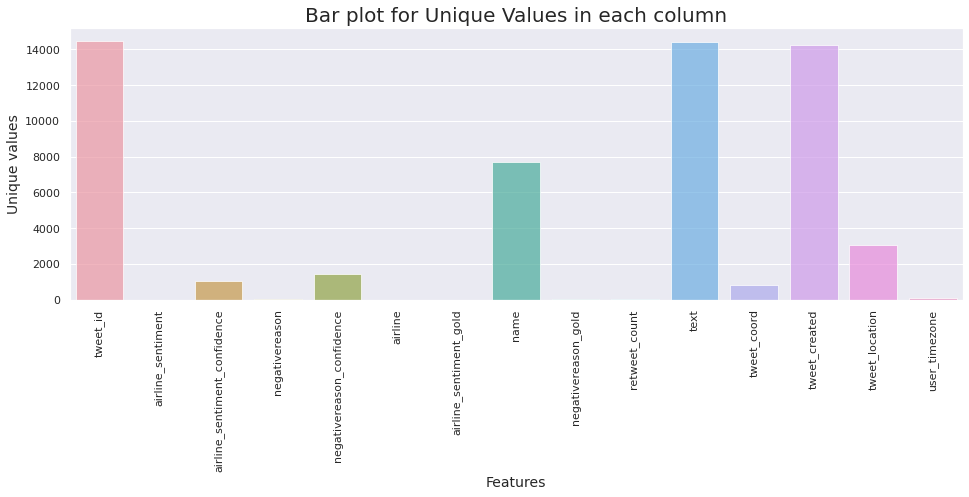

In [197]:

# plot the count of unique values in every column
f, ax = plt.subplots(1,1, figsize=(16,5))
sns.barplot(x=unidf['Features'], y=unidf['Uniques'], alpha=0.7)
plt.title('Bar plot for Unique Values in each column', fontsize=20)
plt.ylabel('Unique values', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.xticks(rotation=90)
plt.show()

In [198]:
# function to create labeled barplots
def labeled_barplot(data, feature,  title, pallet,perc=True, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(16, 4))
    else:
        plt.figure(figsize=(16, 4))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data[feature],
        palette=pallet,
        order=data[feature].value_counts().index[:20],
    )
    ax.set_title('{}'.format(title),fontsize=20)

    for p in ax.patches:
        if perc == True:
            label = "{:1.2f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### **Tweets by Airline**

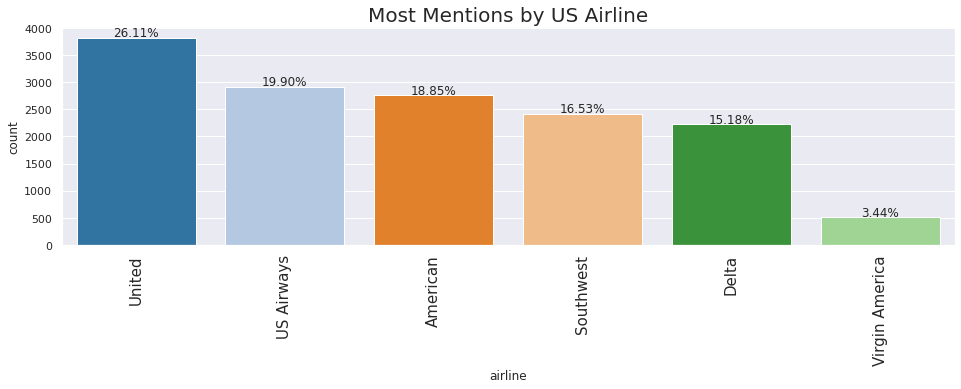

In [199]:
#Visualize the frequency of airline being mentioned
labeled_barplot(df, 'airline', 'Most Mentions by US Airline','tab20')

* United is the most mentioned US Airline, followed by US Airways, American, Southwest, Delta and Virgin America respectively.

###**US Airline Sentiment**

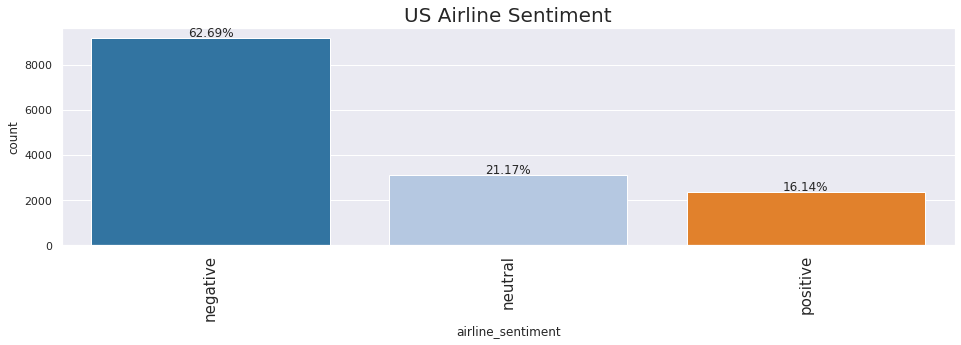

In [200]:
#Visualize the frequency of airline being mentioned
labeled_barplot(df, 'airline_sentiment', 'US Airline Sentiment','tab20')

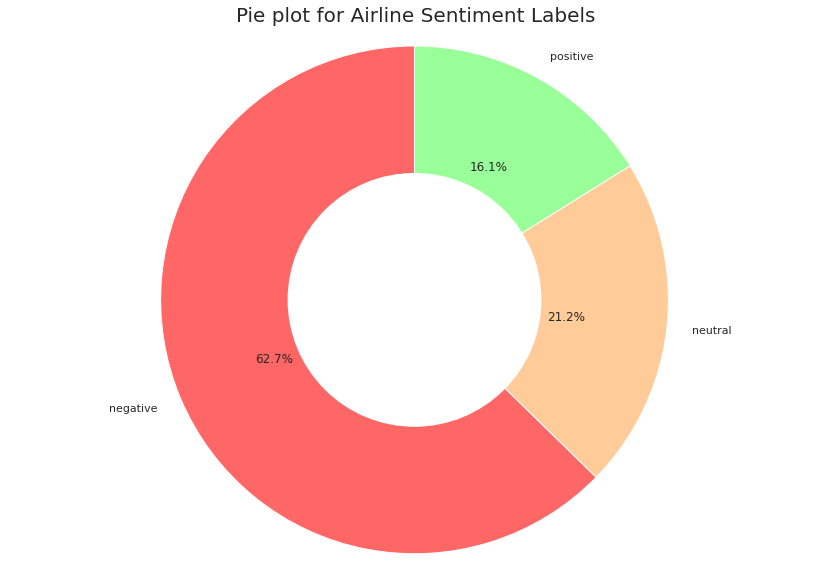

In [201]:
#plot for Airline Sentiment Labels
#Using matplotlib

colors = ['#ff6666', '#ffcc99', '#99ff99']

sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = plt.pie(data['airline_sentiment'].value_counts(), labels=data['airline_sentiment'].value_counts().index, colors=colors, startangle=90,  autopct='%1.1f%%')
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Pie plot for Airline Sentiment Labels', fontsize=20)
#plt.setp(labels, fontsize=15)
plt.axis('equal')
plt.tight_layout()
plt.show()

* **Most of the tweets are negative in nature** (62.7%), which indicates a wide dissatisfaction of US Airlines among travelers, followed by 21.2% neutral and 16.1% neutral tweets.

###**Sentiment by Airline**




airline_sentiment  negative  neutral  positive
airline                                       
American               1960      463       336
Delta                   955      723       544
Southwest              1186      664       570
US Airways             2263      381       269
United                 2633      697       492
Virgin America          181      171       152
airline_sentiment  negative  neutral  positive
airline                                       
American                71%      17%       12%
Delta                   43%      33%       24%
Southwest               49%      27%       24%
US Airways              78%      13%        9%
United                  69%      18%       13%
Virgin America          36%      34%       30%


Text(0.5, 1.0, 'Sentiment by Airline')

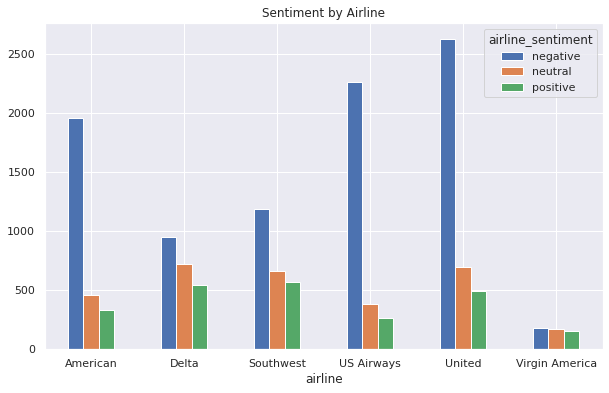

In [202]:
pd.options.display.float_format = '{:.0%}'.format

airlinesentiment=pd.crosstab(index=df['airline'],columns=df['airline_sentiment'])
print(airlinesentiment)

airlinesentiment_pct=pd.crosstab(index=df['airline'],columns=df['airline_sentiment'],normalize='index')
print(airlinesentiment_pct)

# Grouped bar chart between Geography and Exited
airlinesentiment.plot.bar(figsize=(10,6), rot=0)
plt.title('Sentiment by Airline')

Negative Sentiment
* United has the most negative sentiment tweets.
* US Airways has the second most negatives tweets followed by American.
* US Airways has the higest negative sentiment tweets as a portion to all tweets about that airline at 78% negative.
* United has the second highest negative sentiment tweets as a portion to all tweets about it at 71%, followed by American at 69%.

Positive Sentiment
* Southwest has the highest number of positive tweets, followed by Delta and United.
* Virgin America has the highest number of positive tweets proportionally at 30% of all tweets mentioning them.
* Delta and Southwest are tied for the second highest positive tweets proportionally at 24% of all mentions of those airlines.

###**Negative Reasons**

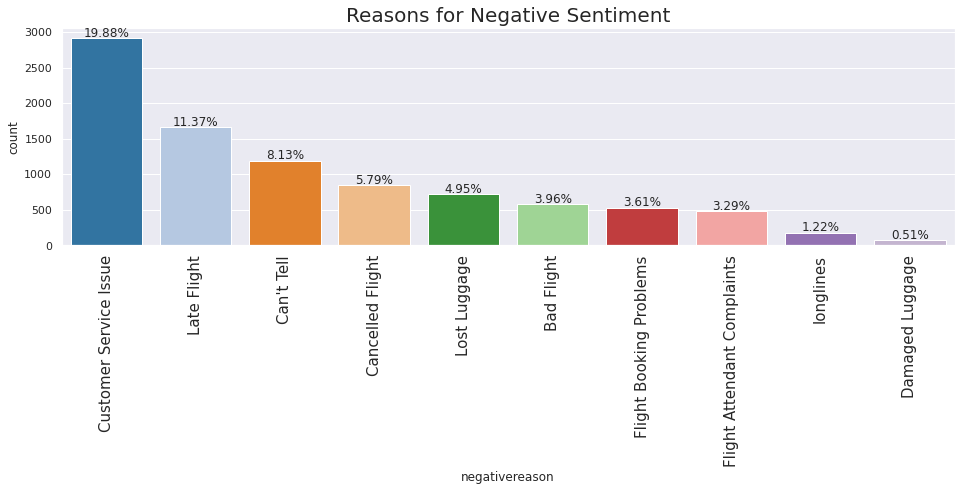

In [203]:
#Visualize the frequency of airline being mentioned
labeled_barplot(df, 'negativereason', 'Reasons for Negative Sentiment','tab20')

* Customer Service issue is the largest category of negative sentiment tweets at just under 20% of negative tweets.
* Late flight, can't tell, cancelled flight, and lost luggage and the other top 5 reasons for negative sentiment respectively.

###**Word Cloud Analysis of Sentiment**

Negative Sentiment

In [204]:
df.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
airline_sentiment_gold              3
name                             7701
negativereason_gold                13
retweet_count                      18
text                            14427
tweet_coord                       832
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

In [205]:
negative_tweets=data[data['airline_sentiment']=='negative']
words = ' '.join(negative_tweets['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [206]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

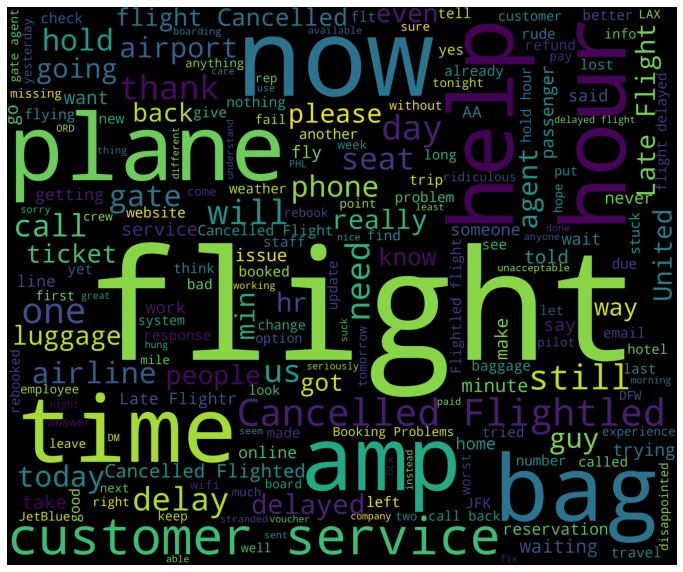

In [207]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

* "Time," "hour," "delay," "delayed," and "late flight" appear. It seems time is a very important factor for US airline customers.
* One of the largest words that appears is "flight." While "customer service" was the number one reason for negative sentiment, it seems like the actual service of delivering a flight is an important driver of negative sentiment.

Positive Sentiment

In [208]:
negative_tweets=data[data['airline_sentiment']=='positive']
words = ' '.join(negative_tweets['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [209]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

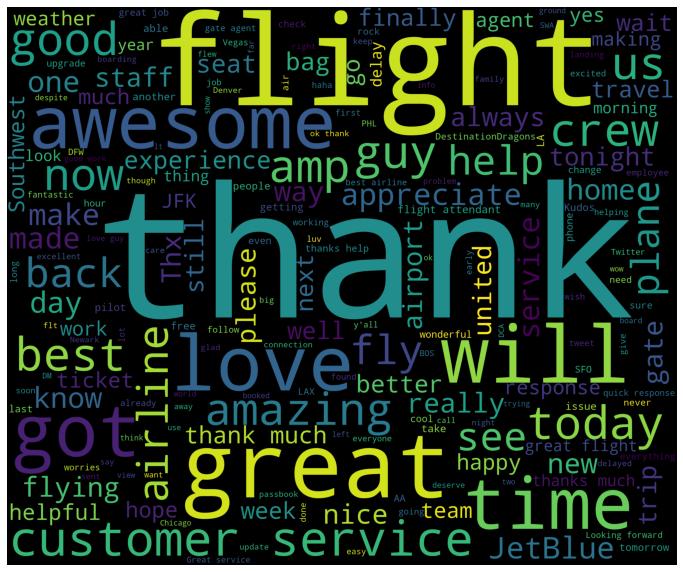

In [210]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

* In both word clouds, "time" appears. It's clear that US airline customers value time.
* In the positive sentiment tweets, it's seems customers are using the platform to express their thanks the airlines.

###**Dropping Unnecessary Data**

In [211]:
df.drop(df.columns.difference(['text','airline_sentiment']), 1, inplace=True)

In [212]:
df.shape

(14640, 2)

In [213]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


###**Data Pre-Processing**
HTML Tag Removal

In [214]:
#remove the html tags
def strip_html(text):
    soup = BeautifulSoup("html.parser")                    
    return soup.get_text()

strip_html(df['text'])
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Tokenization

In [215]:
#tokenizer=ToktokTokenizer()
df['text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) 
df.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, 've, added, comm..."
2,neutral,"[@, VirginAmerica, I, did, n't, today, ..., Mu..."
3,negative,"[@, VirginAmerica, it, 's, really, aggressive,..."
4,negative,"[@, VirginAmerica, and, it, 's, a, really, big..."


Removal of Special Characters and Punctuation

In [216]:
def remove_punctuation(words):
  """Remove punctuation from list of tokenized words"""
  new_words = []
  for word in words:
      new_word = re.sub(r'[^\w\s]', '', word)
      if new_word != '':
          new_words.append(new_word)
  return new_words


df['text'] = df['text'].apply(lambda x: remove_punctuation(x))

df.head()

,airline_sentiment,text
0,neutral,"[VirginAmerica, What, dhepburn, said]"
1,positive,"[VirginAmerica, plus, you, ve, added, commerci..."
2,neutral,"[VirginAmerica, I, did, nt, today, Must, mean,..."
3,negative,"[VirginAmerica, it, s, really, aggressive, to,..."
4,negative,"[VirginAmerica, and, it, s, a, really, big, ba..."


Removal of Numbers

In [217]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

df['text'] =df['text'].apply(str)
df['text'] = df['text'].apply(lambda x: remove_numbers(x))
df.head()

,airline_sentiment,text
0,neutral,"['VirginAmerica', 'What', 'dhepburn', 'said']"
1,positive,"['VirginAmerica', 'plus', 'you', 've', 'added'..."
2,neutral,"['VirginAmerica', 'I', 'did', 'nt', 'today', '..."
3,negative,"['VirginAmerica', 'it', 's', 'really', 'aggres..."
4,negative,"['VirginAmerica', 'and', 'it', 's', 'a', 'real..."


Conversion to Lowercase

In [218]:
df['text'] = df['text'].apply(lambda x:x.lower())
df.head()

,airline_sentiment,text
0,neutral,"['virginamerica', 'what', 'dhepburn', 'said']"
1,positive,"['virginamerica', 'plus', 'you', 've', 'added'..."
2,neutral,"['virginamerica', 'i', 'did', 'nt', 'today', '..."
3,negative,"['virginamerica', 'it', 's', 'really', 'aggres..."
4,negative,"['virginamerica', 'and', 'it', 's', 'a', 'real..."


Removal of Stopwords

In [219]:
stopwords = stopwords.words('english')
stopwords = list(set(stopwords)) 

df['text'].apply(lambda x: [item for item in x if item not in stopwords])


df.head()

,airline_sentiment,text
0,neutral,"['virginamerica', 'what', 'dhepburn', 'said']"
1,positive,"['virginamerica', 'plus', 'you', 've', 'added'..."
2,neutral,"['virginamerica', 'i', 'did', 'nt', 'today', '..."
3,negative,"['virginamerica', 'it', 's', 'really', 'aggres..."
4,negative,"['virginamerica', 'and', 'it', 's', 'a', 'real..."


Joining Words

In [220]:
df['text'] = df['text'].apply(lambda x : x.replace('[', '')).apply(lambda x : x.replace(']', '')).apply(lambda x : x.replace("'", ''))
df['text'] = df['text'].apply(lambda x : x.split(','))
df['text'] = df['text'].agg(' '.join)

df.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn said
1,positive,virginamerica plus you ve added commercia...
2,neutral,virginamerica i did nt today must mean ...
3,negative,virginamerica it s really aggressive to ...
4,negative,virginamerica and it s a really big bad...


Lemmatize/Stemming

In [221]:
lemmatizer = WordNetLemmatizer()


def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

df.text.apply(lemmatize_text)



df.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn said
1,positive,virginamerica plus you ve added commercia...
2,neutral,virginamerica i did nt today must mean ...
3,negative,virginamerica it s really aggressive to ...
4,negative,virginamerica and it s a really big bad...


Data After Pre-Processing

In [222]:
df.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn said
1,positive,virginamerica plus you ve added commercia...
2,neutral,virginamerica i did nt today must mean ...
3,negative,virginamerica it s really aggressive to ...
4,negative,virginamerica and it s a really big bad...


###**Vectorization**

In [223]:
Count_vec = CountVectorizer(max_features=500)              
data_features = Count_vec.fit_transform(df['text'])

data_features = data_features.toarray()        

In [224]:
data_features.shape       #Shape of the feature vector

(14640, 500)

In [225]:
X = data_features

y = df.airline_sentiment

In [226]:
y.head()

0     neutral
1    positive
2     neutral
3    negative
4    negative
Name: airline_sentiment, dtype: object

In [227]:
data_features = Count_vec.fit_transform(df['text'])

In [228]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [229]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [230]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

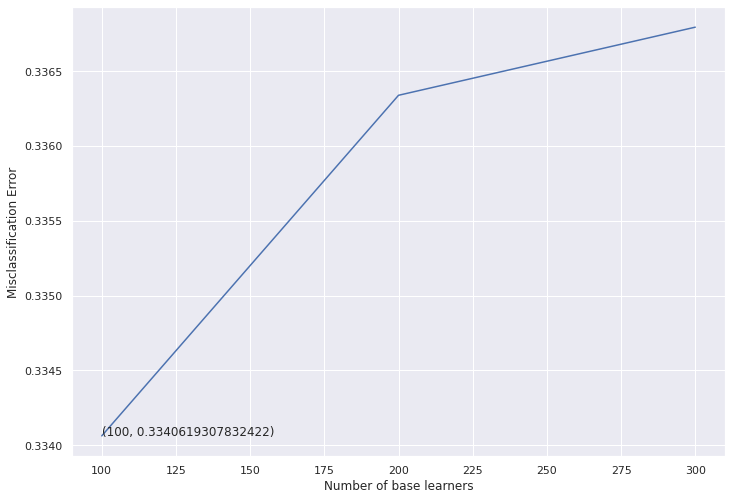

In [231]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

Count Vectorization

In [232]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
count_vectorizer_predicted = clf.predict(X_test)
print(classification_report(y_test ,count_vectorizer_predicted , target_names = ['positive' , 'negative', 'neutral']))
print("Accuracy of the model is : ",accuracy_score(y_test,count_vectorizer_predicted))

              precision    recall  f1-score   support

    positive       0.82      0.95      0.88      2627
    negative       0.60      0.30      0.40       577
     neutral       0.75      0.55      0.64       456

    accuracy                           0.80      3660
   macro avg       0.73      0.60      0.64      3660
weighted avg       0.78      0.80      0.78      3660

Accuracy of the model is :  0.7994535519125683


[[2499   84   44]
 [ 364  174   39]
 [ 173   30  253]]


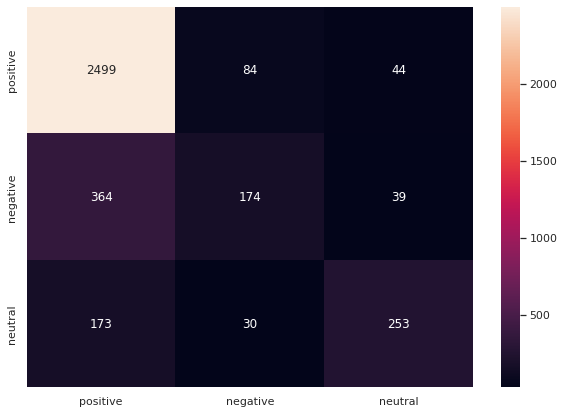

In [233]:

conf_mat = confusion_matrix(y_test, count_vectorizer_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['positive' , 'negative', 'neutral']],
                  columns = [i for i in ['positive' , 'negative', 'neutral']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

thanks,thank,usairways,no,nt,to,not,united,jetblue,http,great,the,you,and,flight,is,for,on,my,southwestair,your,can,it,in,love,delayed,that,of,was,but,do,hold,awesome,me,have,hours,virginamerica,just,why,this,
 
 


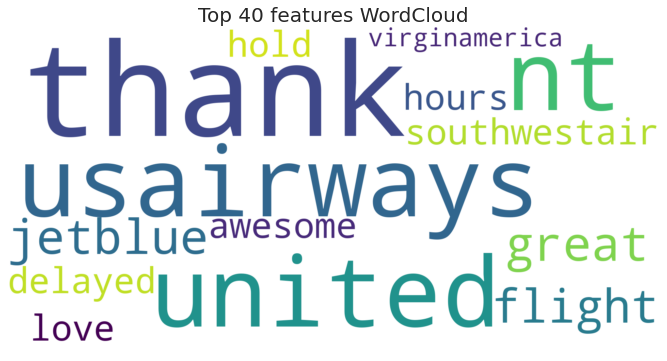

In [234]:
all_features = Count_vec.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','
    
print(top_features)  

print(" ") 
print(" ")     

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

TF-IDF

In [235]:

tfidf_vect = TfidfVectorizer(max_features=500)
data_features = tfidf_vect.fit_transform(df['text'])

data_features = data_features.toarray()

data_features.shape     #feature shape

(14640, 500)

In [236]:
tfs = tfidf.fit_transform(df['text'])

In [167]:
X = data_features

y = data.airline_sentiment

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [169]:
base_ln = np.arange(100,400,100).tolist()
base_ln

[100, 200, 300]

In [170]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

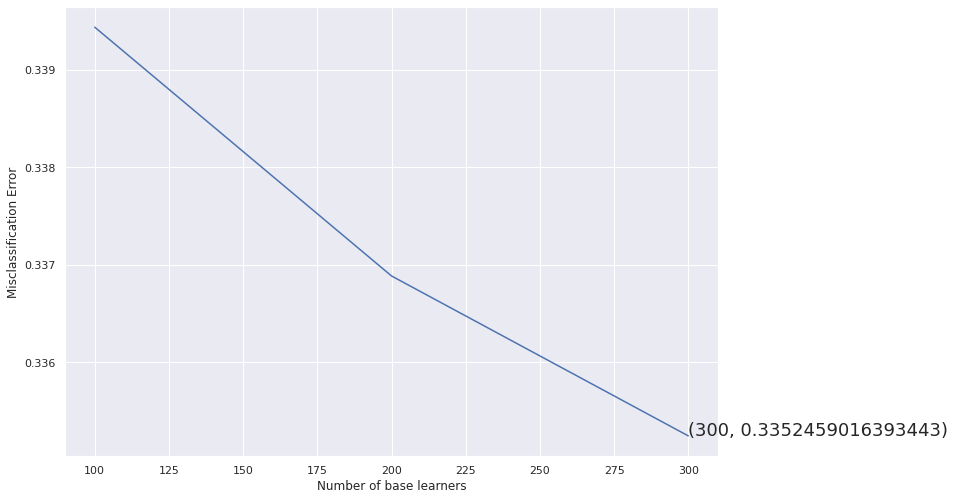

In [171]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [173]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
tf_idf_predicted = clf.predict(X_test)
print(classification_report(y_test , tf_idf_predicted , target_names = ['positive' , 'negative', 'neutral']))
print("Accuracy of the model is : ",accuracy_score(y_test,tf_idf_predicted))

              precision    recall  f1-score   support

    positive       0.80      0.97      0.88      2627
    negative       0.68      0.21      0.33       577
     neutral       0.77      0.54      0.63       456

    accuracy                           0.80      3660
   macro avg       0.75      0.57      0.61      3660
weighted avg       0.78      0.80      0.76      3660

Accuracy of the model is :  0.7950819672131147


[[2542   46   39]
 [ 418  124   35]
 [ 199   13  244]]


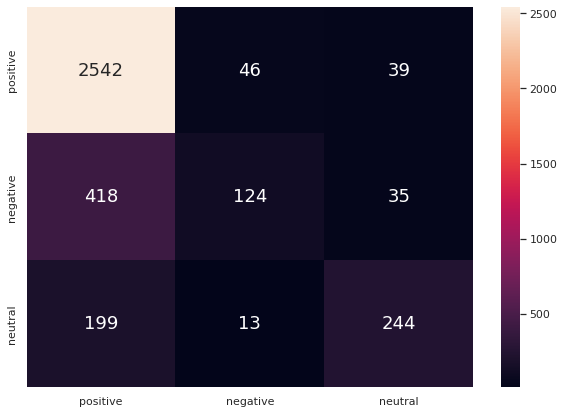

In [175]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, tf_idf_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['positive' , 'negative', 'neutral']],
                  columns = [i for i in ['positive' , 'negative', 'neutral']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

thanks, thank, jetblue, southwestair, united, http, usairways, you, to, great, the, nt, can, no, not, and, for, virginamerica, on, is, flight, my, love, your, in, it, awesome, do, of, that, was, from, me, have, but, any, delayed, just, hold, amazing, 
 
 


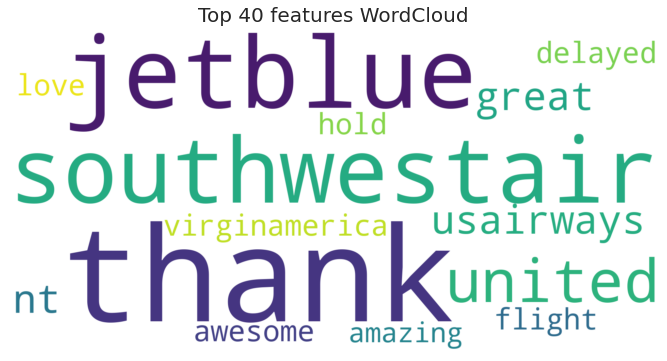

In [176]:
all_features = tfidf_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=', '
    
print(top_features)  

print(" ") 
print(" ") 

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

### **Comparing the Models: Count Vectorizer vs TF-IDF**

In [177]:

df = pd.DataFrame(y_test.tolist(),columns =['y_test'])
df['count_vectorizer_predicted'] = count_vectorizer_predicted
df['tf_idf_predicted'] = tf_idf_predicted
df.head()

,y_test,count_vectorizer_predicted,tf_idf_predicted
0,negative,negative,negative
1,negative,negative,negative
2,negative,negative,negative
3,negative,negative,negative
4,positive,negative,negative


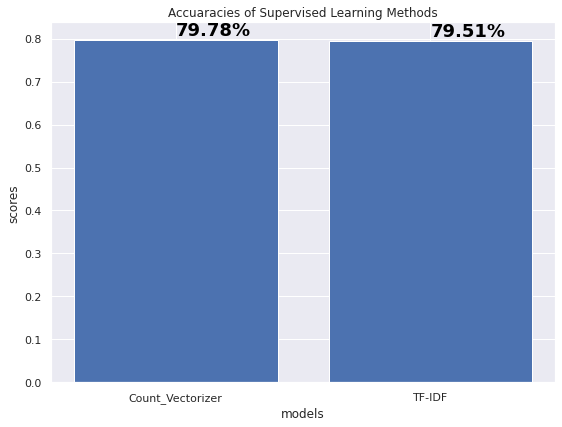

In [178]:
#create bar plot to compare the accuaracies of Count Vectorizer and TF-IDF
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
subjects = ['Count_Vectorizer', 'TF-IDF']

# calculation accuracies of Count Vectorizer and TF-IDF using accuracy_score metrics
scores = [accuracy_score(y_test,count_vectorizer_predicted),accuracy_score(y_test,tf_idf_predicted)]
ax.bar(subjects,scores)
ax.set_ylabel('scores',fontsize= 12)    # y axis label
ax.set_xlabel('models',fontsize= 12)    # x axis label
ax.set_title('Accuaracies of Supervised Learning Methods')  # tittle
for i, v in enumerate(scores):
    ax.text( i ,v+0.01, '{:.2f}%'.format(100*v), color='black', fontweight='bold')     
    plt.savefig('barplot_1.png',dpi=100, format='png', bbox_inches='tight')
plt.show()

* Count Vectorizer shows marginally better performance than TF-IDF, however, **both models have comparable performance** on this data. 
* TF-IDF is often the more preferable model because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. Words can then be removed that are less important for analysis, reducing the input dimensions and thereby making the model building less complex.

# **Conclusions**
- The US Airline Customer for this week in February of 2015 on Twitter is generally more dissatisfied with the airlines than satisfied.
- All airlines have more negative sentiment tweets about them compared to neutral or positive sentiment tweets. It seems that, generally, more US Airline customers are inclined to tweet mentioning US Airlines more when they're dissatisfied.
- All US Airlines can benefit from reviewing negative sentiment tweets to improve their airline service, customer service, and problem resolution in addition to taking the opportunity to respond to dissatisfied sentiment on Twitter in attempt to mitigate bad sentiment.
- United, US Airways, American all have around 70% or more negative sentiment tweets out of all the tweets mentioning them. These airlines would particularily benefit from analyzing the negative sentiment tweets to improve their service for customers and mitigate bad sentiment around their brand.
- Virigin America, Delta and Southwest, while they all have more negative sentiment tweets than positive or neutral, generally have the better sentiment on Twitter for this time period with Virigin America having the best overall sentiment.
- An NLP model was created that accurately categorizes the sentiment of tweets about US Airlines roughly 80% of the time.
- Both the Count Vectorizer model and the Tf-IDF model yielded very similar results in accurately predicting the sentiment of tweets regarindg US Airlines with the Count Vectorizer model being marginally more accurate.